# Guides to LiDAR (Part 2b - Using GDAL in Creating Hillshades) 



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Access" data-toc-modified-id="Data-Access-1">Data Access</a></span><ul class="toc-item"><li><span><a href="#Data-Tiers" data-toc-modified-id="Data-Tiers-1.1">Data Tiers</a></span></li><li><span><a href="#The-Chain-of-Processes" data-toc-modified-id="The-Chain-of-Processes-1.2">The Chain of Processes</a></span></li><li><span><a href="#Study-Area" data-toc-modified-id="Study-Area-1.3">Study Area</a></span></li></ul></li><li><span><a href="#GDAL-usage" data-toc-modified-id="GDAL-usage-2">GDAL usage</a></span><ul class="toc-item"><li><span><a href="#Query-the-metadata-properties" data-toc-modified-id="Query-the-metadata-properties-2.1">Query the metadata properties</a></span></li><li><span><a href="#Calculate-Hillshade" data-toc-modified-id="Calculate-Hillshade-2.2">Calculate Hillshade</a></span></li><li><span><a href="#Calculate-CHM-&amp;-Overlay-on-Top-of-Hillshade" data-toc-modified-id="Calculate-CHM-&amp;-Overlay-on-Top-of-Hillshade-2.3">Calculate CHM &amp; Overlay on Top of Hillshade</a></span></li></ul></li><li><span><a href="#Links-to-Tutorials-on-Creating-Hillshades" data-toc-modified-id="Links-to-Tutorials-on-Creating-Hillshades-3">Links to Tutorials on Creating Hillshades</a></span></li></ul></div>

## Data Access

### Data Tiers

The **National Ecological Observatory Network (NEON)** provides everyone access to Open data of LiDAR to help understand how aquatic and terrestrial ecosystems are changing. There are three ways getting airborne LiDAR data, you can either download the data from the <a href="http://data.neonscience.org/static/browse.html">**NEON data portal**</a> (recommended for smaller amounts of data), programmatically access the data with the <a href="http://data.neonscience.org/data-api">**NEON Data API**</a> or using the <a href="https://github.com/NEONScience/NEON-utilities">**NEON Utilities**</a> GitHub repo (>1 GB downloads), or mail in a hard drive to receive your data. Based on the file size and your convenience, it is up to your own decision in choosing how to access the data. Listed below is the types of LiDAR data provided on NEON, and the estimated sizes:

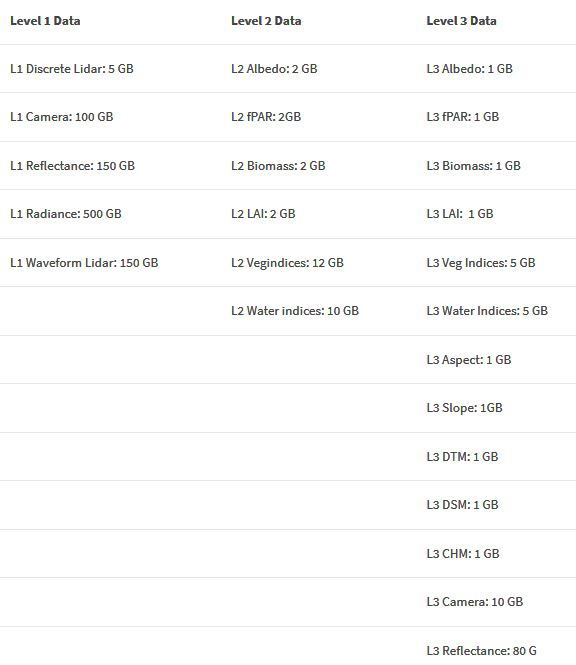
<figcaption><center>Fig 1. Types of LiDAR data provided on NEON, and the estimated sizes (Source: NEON).</center></figcaption>

### The Chain of Processes

**NEON** has been through all the complexities in providing the direct data access to users. For example, in terms of DSM and DTM, **NEON** runs a chain of processes in deriving the elevation models from the original LAS files:

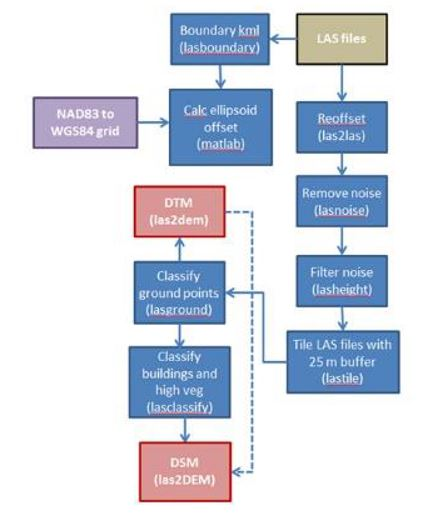
<figcaption><center>Fig 2. A chain of processes in deriving the elevation models from the original LAS files run by NEON (Source: NEON).</center></figcaption>

In this tutorial, we will learn how to create a **hillshade** from a terrain raster using GDAL, under the condition that the **DTM, DSM, and CHM** data can be downloaded directly from the Level 3 tier data portal (namely, **L3_DSM, L3_DTM, and L3_CHM**).

### Study Area

Also to note, the study area being picked is the `Lower Teakettle (TEAK)`. <a href="https://www.neonscience.org/field-sites/field-sites-map/TEAK">Lower Teakettle</a> is part of the Sierra National Forest, federal public land administered by the U.S. Forest Service. The land is managed for multiple uses and benefits, ranging from renewable resources, such as timber and forage, to recreation and research. Targeted research addresses a range of concerns and provides much of the direction in resource management. The southernmost portion of TEAK overlaps with the Teakettle Experimental Forest, managed by the Pacific Southwest Research Station, which represents the Forest Service Research and Development (FS R&D). 

The National Land Cover Database (NLCD) classifies Lower Teakettle as evergreen forest and shrub scrub vegetation types. At a finer scale, it is a mosaic of closed canopy pine and fir forest, shrub patches, and areas of exposed rock and shallow soil, with occasional wet meadows. The site encompasses 5,138 hectares (12,696 acres) of mixed conifer and red fir forest, ranging in elevation from 1,990 to 2,807 m (6,529 – 9,209ft). The varied terrain is typical of the Sierra Nevada, with rugged mountains, meadows and prominent granite outcrops. TEAK has been designated as one of two relocatable terrestrial sites for the Pacific Southwest domain.

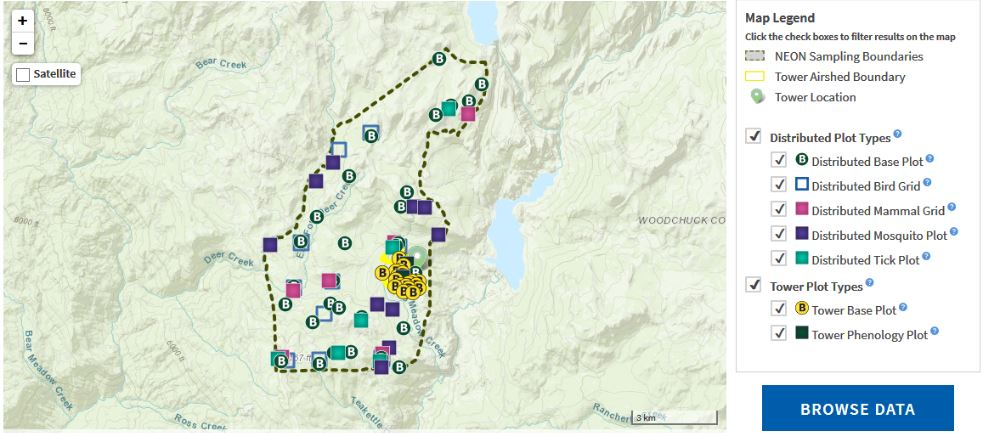
<figcaption><center>Fig 3. The TEAK study sites as picked and mapped by NEON (Source: NEON).</center></figcaption>

To learn more about the site, please check the YouTube video below:

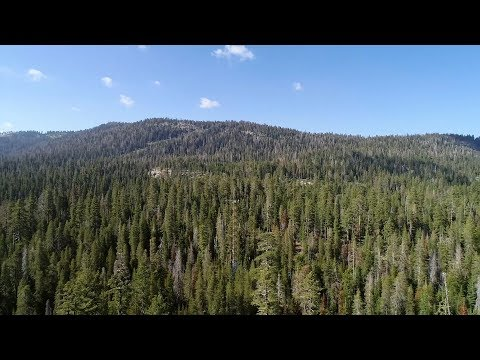

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('XrxZy7Dp4ko')

## GDAL usage

First, let's import the required packages and set plot display to inline:

In [2]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Also, we need to define the following utility functions:
- ```raster2array``` which reads in the first band of geotif file and returns an array and associated metadata dictionary.
- ```plotbandarray``` which draws the band array with colormap, along with title, label, and customized transparency.

In [1]:
def raster2array(geotif_file):
    """
    # Input: 
    #   raster_geotif (e.g. 'raster.tif')
    # Outputs:
    #   array_rows: # of rows in the array
    #   array_cols: # of columns in the array
    #   bands: # of bands 
    #   driver: (for NEON data this is Geotif)
    #   projection: 
    #   geotransform: 
    #   pixelWidth: width of pixel (for NEON data this = 1)
    #   pixelHeight: height of pixel (for NEON data this = -1)
    #   ext_dict: dictionary of raster extent, containing the following information 
    #           {'xMin': xMin_value,'xMax': xMax_value, 'yMin': yMin_value, 'yMax': yMax_value}
    #           Note: to extract a value from ext_dict, use the syntax: eg. xMin = metadata['ext_dict']['xMin']
    #   extent: raster extent values (xMin, xMax, yMin, yMax)
    #   noDataValue: no data value 
    #   scaleFactor: scale factor 
    #   band_stats: dictionary of statistics for band 1:
    #           {'min': min_value, 'max': max_value, 'mean': mean_value, 'stdev': stdev_value}
    #           Note: to extract a value from band_stats dictionary, use the syntax: 
    #                 eg. array_min = metadata['band_stats']['min']

    # Usage: array, metadata = raster2array('raster.tif')
    """
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]
    metadata['xMin'] = mapinfo[0]
    metadata['yMax'] = mapinfo[3]
    metadata['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} # make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... fix function for case of multiple bands')

In [3]:
def plot_band_array(band_array, refl_extent, title, cbar_label, colormap='spectral', alpha=1):
    """
    # Input: 
    #   band_array (e.g. the first component of returned object from raster2array method)
    #   refl_extent: the extents of band array
    #   title: the title of the plot to be displayed at the top center
    #   cbar_label: the label to be displayed on the right to the y-axis
    #   colormap: pick the schema for color map
    #   alpha: choose the transparency from 0 to 1
    # Outputs:
    #   plot the rows and columns of a band array

    # Usage: plot_band_array(dtm_array, dtm_metadata['extent'],'TEAK DTM','Elevation, m',colormap='gist_earth')
    """
    plt.imshow(band_array,extent=refl_extent,alpha=alpha); 
    
    cbar = plt.colorbar(); 
    plt.set_cmap(colormap); 
    cbar.set_label(cbar_label,rotation=270,labelpad=20)
    plt.title(title); 
    
    ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') # do not use scientific notation
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) # rotate x tick labels 90 degree

### Query the metadata properties

In [10]:
#Importing the TEAK CHM Geotiff resulted in v. sparse data ?
chm_array, chm_metadata = raster2array(r"<Root Folder>\lidar_files\2013_TEAK_1_326000_4103000_pit_free_CHM.tif")

print('TEAK CHM Array\n:',chm_array)

#print metadata in alphabetical order
for item in sorted(chm_metadata):
    print(item + ':', chm_metadata[item])
    
import copy
chm_nonzero_array = copy.copy(chm_array)
chm_nonzero_array[chm_array==0]=np.nan
print('TEAK CHM nonzero array:\n',chm_nonzero_array)
print(np.nanmin(chm_nonzero_array))
print(np.nanmax(chm_nonzero_array))

TEAK CHM Array
: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [28.65999985 28.37999916 19.11000061 ...  0.          0.
   0.        ]
 [29.37999916 29.19000053 28.39999962 ...  0.          0.
   0.        ]
 [30.25       29.51000023 29.         ...  0.          0.
   0.        ]]
array_cols: 1000
array_rows: 1000
bands: 1
bandstats: {'min': 0.0, 'max': 59.96, 'mean': 8.84, 'stdev': 11.82}
driver: GeoTIFF
ext_dict: {'xMin': 326000.0, 'xMax': 327000.0, 'yMin': 4103000.0, 'yMax': 4104000.0}
extent: (326000.0, 327000.0, 4103000.0, 4104000.0)
geotransform: (326000.0, 1.0, 0.0, 4104000.0, 0.0, -1.0)
noDataValue: -9999.0
pixelHeight: -1.0
pixelWidth: 1.0
projection: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326

###  Calculate Hillshade

<img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade_files/image001.gif" style="width: 250px;"/>
<figcaption><center>Fig 4. How hillshade is calculated (Source: <font size="2">http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade.htm</font>)</center>


Hillshade is used to visualize the hypothetical illumination value (from 0-255) of each pixel on a surface given a specified light source. To calculate hillshade, we need the zenith (altitude) and azimuth of the illumination source, as well as the slope and aspect of the terrain. The formula for hillshade is:

$$Hillshade = 255.0 * (( cos(zenith_I)*cos(slope_T))+(sin(zenith_I)*sin(slope_T)*cos(azimuth_I-aspect_T))$$

Where all angles are in radians. 

For more information about how hillshades work, please refer to the <a href="http://webhelp.esri.com/arcgisdesktop/9.2/index.cfm?TopicName=How%20Hillshade%20works">ESRI ArcGIS Help page</a>. 

In [4]:
def hillshade(array, azimuth, angle_altitude):
    """
    # Input: 
    #   array (e.g. the first component of returned object from raster2array method)
    #   azimuth:
    #   angle_altitude
    # Outputs:
    #   the hillshade array with values from 0 to 255
    # Source: https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py
    # Usage: array = hillshade(dtm_array, 225, 45)
    """
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

Now that we have a function to generate hillshade, we need to read in the NEON LiDAR Digital Terrain Model (DTM) geotif using the ```raster2array``` function and then calculate hillshade using the ```hillshade``` function. We can then plot both using the ```plot_band_array``` function. 

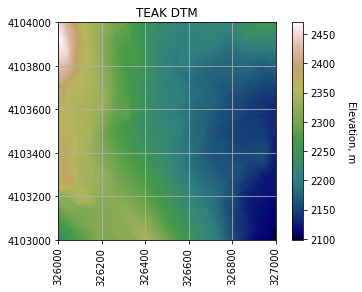

In [5]:
# Use raster2array to convert TEAK DTM Geotif to array & plot
dtm_array, dtm_metadata = raster2array(r"<Root Folder>\lidar_files\2013_TEAK_1_326000_4103000_DTM.tif")
plot_band_array(dtm_array, dtm_metadata['extent'], 'TEAK DTM', 'Elevation, m', colormap='gist_earth')
ax = plt.gca(); plt.grid('on')

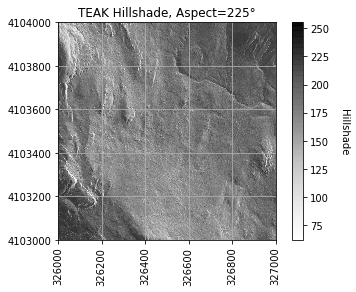

In [6]:
# Use hillshade function on a DTM Geotiff
hs_array = hillshade(dtm_array, 225, 45)
plot_band_array(hs_array, dtm_metadata['extent'], 'TEAK Hillshade, Aspect=225°',
                'Hillshade', colormap='Greys', alpha=0.8)
ax = plt.gca(); plt.grid('on') 

Text(0.5, 1.0, 'TEAK Hillshade + DTM')

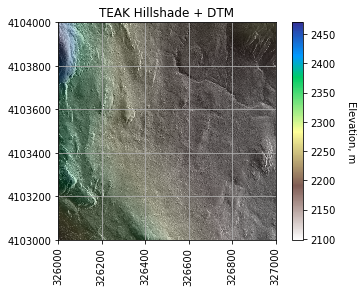

In [7]:
#Overlay transparent hillshade on DTM:
fig = plt.figure(frameon=False)
im1 = plt.imshow(dtm_array, cmap='terrain_r', extent=dtm_metadata['extent']); 
cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(hs_array, cmap='Greys', alpha=0.8, extent=dtm_metadata['extent']); # plt.colorbar()
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') # do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90) # rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK Hillshade + DTM')

### Calculate CHM & Overlay on Top of Hillshade

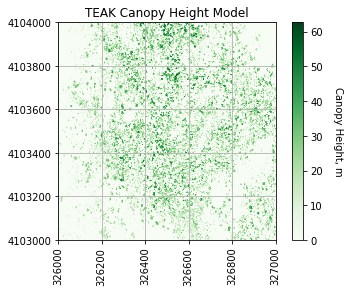

In [8]:
#Calculate CHM from DSM & DTM:
dsm_array, dsm_metadata = raster2array(r"<Root Folder>\lidar_files\2013_TEAK_1_326000_4103000_DSM.tif")
teak_chm = dsm_array - dtm_array;

plot_band_array(teak_chm,dtm_metadata['extent'], 'TEAK Canopy Height Model', 'Canopy Height, m', colormap='Greens')
ax = plt.gca(); plt.grid('on')

Text(0.5, 1.0, 'TEAK 2013 \n Terrain, Hillshade, & Canopy Height')

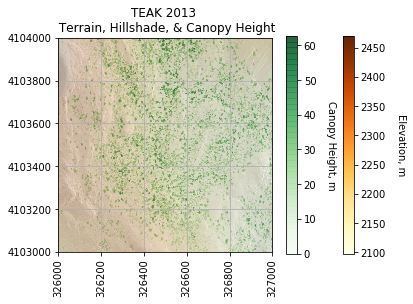

In [9]:
#Overlay transparent hillshade on DTM:
fig = plt.figure(frameon=False)

#Terrain
im1 = plt.imshow(dtm_array, cmap='YlOrBr', extent=dtm_metadata['extent']); 
cbar1 = plt.colorbar(); cbar1.set_label('Elevation, m', rotation=270, labelpad=20)

#Hillshade
im2 = plt.imshow(hs_array, cmap='Greys', alpha=.5, extent=dtm_metadata['extent']); #plt.colorbar()

#Canopy
im3 = plt.imshow(teak_chm, cmap='Greens', alpha=0.6, extent=dtm_metadata['extent']); 
cbar2 = plt.colorbar(); cbar2.set_label('Canopy Height, m',rotation=270,labelpad=20)
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') # do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90) # rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK 2013 \n Terrain, Hillshade, & Canopy Height')

## Links to Tutorials on Creating Hillshades

**ESRI ArcGIS Hillshade Algorithm:**
- http://webhelp.esri.com/arcgisdesktop/9.2/index.cfm?TopicName=How%20Hillshade%20works

**GitHub Hillshade Functions/Tutorials:**
- https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py
- https://github.com/clhenrick/gdal_hillshade_tutorial

**GDAL Hillshade:**
- http://www.gdal.org/gdaldem.html
- http://gis.stackexchange.com/questions/144535/how-to-create-transparent-hillshade/144700

**Python Hillshade:**
- http://geoexamples.blogspot.com/2014/03/shaded-relief-images-using-gdal-python.html
- http://pangea.stanford.edu/~samuelj/musings/dems-in-python-pt-3-slope-and-hillshades-.html

<a href="#Table-of-Contents">Back to the Top</a>